In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('omw-1.4')

from nltk.corpus import stopwords

import spacy
from textacy import preprocessing
import en_core_web_sm
from textblob import TextBlob

from tqdm import tqdm
tqdm.pandas()

from wordcloud import WordCloud
import matplotlib.gridspec as gridspec
from scipy.stats import chi2_contingency

import seaborn as sns
import matplotlib.pyplot as plt

import string
from functools import partial
import contractions
import re

import gensim.downloader as api
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings 

seed = 99

sns.set_style("darkgrid")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Miguel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Miguel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Miguel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\Miguel\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Miguel\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Miguel\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already u

In [2]:
dataset = pd.read_csv("gamestop_product_reviews_dataset_sample.csv")

## 0. Observacion preliminar

In [3]:
display(dataset.shape)
pd.set_option('display.max_columns', 21)
dataset.head()

(4686, 21)

,index,url,name,brand,sku,reviewer_name,review_title,review_description,recommended_review,verifed_purchaser,helpful_count,not_helpful_count,reviewed_at,images,rating,average_rating,reviews_count,reviews_link,comment_id,uniq_id,scraped_at
0,0,https://www.gamestop.com/electronics/tvs-monit...,VIZIO 55-in Class OLED 4K HDR Smart TV OLED55-H1,VIZIO,328244,Leeford,NaN,My new OLED is a upgrade and it's great! This...,yes: I recommend this product,NaN,0,0,10 months ago,NaN,5.0,4.2727,363,https://www.gamestop.com/on/demandware.store/S...,229196240,d749678d-aeba-5a6b-b8e2-8d2121463672,16/01/2022 16:17:56
1,1,https://www.gamestop.com/electronics/tvs-monit...,VIZIO 55-in Class OLED 4K HDR Smart TV OLED55-H1,VIZIO,328244,DJM7,Great looking screen!,Rating is really a 4.5 but that's unavailable....,yes: I recommend this product,NaN,0,0,10 months ago,NaN,4.0,4.2727,363,https://www.gamestop.com/on/demandware.store/S...,229179703,9f20312c-1047-5824-97d2-d5563b8fd046,16/01/2022 16:17:56
2,2,https://www.gamestop.com/electronics/tvs-monit...,VIZIO 55-in Class OLED 4K HDR Smart TV OLED55-H1,VIZIO,328244,EC82,Quality,I’m quite pleased with the entire product as a...,yes: I recommend this product,NaN,0,0,10 months ago,NaN,4.0,4.2727,363,https://www.gamestop.com/on/demandware.store/S...,229174444,178b3b03-2c56-5abc-a016-c74c2633c9c2,16/01/2022 16:17:56
3,3,https://www.gamestop.com/electronics/tvs-monit...,VIZIO 55-in Class OLED 4K HDR Smart TV OLED55-H1,VIZIO,328244,Weeto,Unbelievable picture quality!,I’ve only had my new Visio OLED65 mounted and ...,yes: I recommend this product,NaN,0,0,10 months ago,NaN,2.0,4.2727,363,https://www.gamestop.com/on/demandware.store/S...,229167959,16e925e3-1e59-537e-aa67-1675b613d351,16/01/2022 16:17:56
4,4,https://www.gamestop.com/electronics/tvs-monit...,VIZIO 55-in Class OLED 4K HDR Smart TV OLED55-H1,VIZIO,328244,LexusSC400,Vizio OLED,The picture is very crisp and the blacks very ...,yes: I recommend this product,NaN,0,0,10 months ago,NaN,5.0,4.2727,363,https://www.gamestop.com/on/demandware.store/S...,229131414,bc017585-3bc1-5a37-9e58-f0bed6de9a72,16/01/2022 16:17:56


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4686 entries, 0 to 4685
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               4686 non-null   int64  
 1   url                 4686 non-null   object 
 2   name                4686 non-null   object 
 3   brand               4686 non-null   object 
 4   sku                 4686 non-null   int64  
 5   reviewer_name       4686 non-null   object 
 6   review_title        4621 non-null   object 
 7   review_description  4686 non-null   object 
 8   recommended_review  4686 non-null   object 
 9   verifed_purchaser   2406 non-null   object 
 10  helpful_count       4686 non-null   int64  
 11  not_helpful_count   4686 non-null   int64  
 12  reviewed_at         4686 non-null   object 
 13  images              166 non-null    object 
 14  rating              4686 non-null   float64
 15  average_rating      4686 non-null   float64
 16  review

,index
recommended_review,
No: I don’t recommend this product,1465
yes: I recommend this product,3221


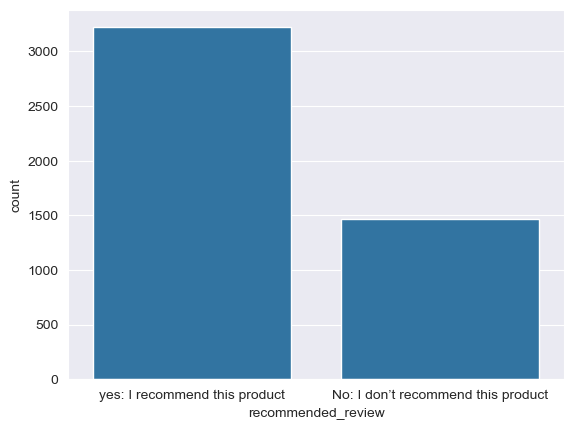

In [5]:
sns.countplot(x ='recommended_review', data = dataset)
dataset.groupby(['recommended_review']).agg({"index":"count"})

In [6]:
dataset.nunique()

index                 4686
url                    124
name                   124
brand                   70
sku                    124
reviewer_name         4452
review_title          3831
review_description    4684
recommended_review       2
verifed_purchaser        1
helpful_count           38
not_helpful_count       45
reviewed_at             57
images                 166
rating                   5
average_rating          92
reviews_count           72
reviews_link           543
comment_id            4686
uniq_id               4686
scraped_at              95
dtype: int64

In [7]:
dataset.isna().sum()

index                    0
url                      0
name                     0
brand                    0
sku                      0
reviewer_name            0
review_title            65
review_description       0
recommended_review       0
verifed_purchaser     2280
helpful_count            0
not_helpful_count        0
reviewed_at              0
images                4520
rating                   0
average_rating           0
reviews_count            0
reviews_link             0
comment_id               0
uniq_id                  0
scraped_at               0
dtype: int64

### 0.1 Limpieza de datos

In [8]:
dataset = dataset.drop(["url","images","comment_id","uniq_id","scraped_at","reviews_link","sku","reviewer_name","index","helpful_count","not_helpful_count"],axis=1)

In [9]:
dataset.head(2)

,name,brand,review_title,review_description,recommended_review,verifed_purchaser,reviewed_at,rating,average_rating,reviews_count
0,VIZIO 55-in Class OLED 4K HDR Smart TV OLED55-H1,VIZIO,NaN,My new OLED is a upgrade and it's great! This...,yes: I recommend this product,NaN,10 months ago,5.0,4.2727,363
1,VIZIO 55-in Class OLED 4K HDR Smart TV OLED55-H1,VIZIO,Great looking screen!,Rating is really a 4.5 but that's unavailable....,yes: I recommend this product,NaN,10 months ago,4.0,4.2727,363


**Dimensiones del dataset**
  - Observamos el número de documentos y variables como ya se habia observado de forma preliminar con el método .info(). 

In [10]:
print("El conjunto de reviews tiene {} documentos".format(len(dataset)))
print("El dataframe tiene {} columnas".format(dataset.shape[1]))

El conjunto de reviews tiene 4686 documentos
El dataframe tiene 10 columnas


**Duplicados**
  - Comprobamos si existen documentos duplicados en cuanto al texto de las reviews. 

In [11]:
print("Existen {} reviews duplicadas".format(np.sum(dataset.duplicated(subset=["review_description"])))) 

Existen 2 reviews duplicadas


In [12]:
dataset.drop_duplicates(inplace=True)

**Valores nulos**
  - Comprobamos que no haya execsivos nulls en ningunas de las columnas del dataset

In [13]:
dataset.isna().sum()

name                     0
brand                    0
review_title            65
review_description       0
recommended_review       0
verifed_purchaser     2278
reviewed_at              0
rating                   0
average_rating           0
reviews_count            0
dtype: int64

Se limpian los nulls de verified purchase y se convierte en tipo int para ahorrar memoria.

In [14]:
dataset["verifed_purchaser"] = dataset["verifed_purchaser"].fillna(0).replace({"Verified Purchaser":1}).astype(int)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_4160\1077654209.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["verifed_purchaser"] = dataset["verifed_purchaser"].fillna(0).replace({"Verified Purchaser":1}).astype(int)


Se realiza lo mismo con la variable "recommended_review".

In [15]:
dataset["recommended_review"] = dataset["recommended_review"].replace({"yes: I recommend this product":1,"No: I don’t recommend this product":0}).astype(int)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_4160\3265685833.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["recommended_review"] = dataset["recommended_review"].replace({"yes: I recommend this product":1,"No: I don’t recommend this product":0}).astype(int)


**Distribución de la longitud de las reviews en caracteres:**

Calculamos la longitud de cada uno de los textos de los documentos para después dibujar su histograma, de esta forma podremos comprobar si es un parámetro que pudiera ayudar en la clasificación de las reviews.

In [16]:
dataset["char_len"] = dataset["review_description"].progress_apply(lambda x: len(x))

100%|██████████| 4684/4684 [00:00<00:00, 519601.16it/s]

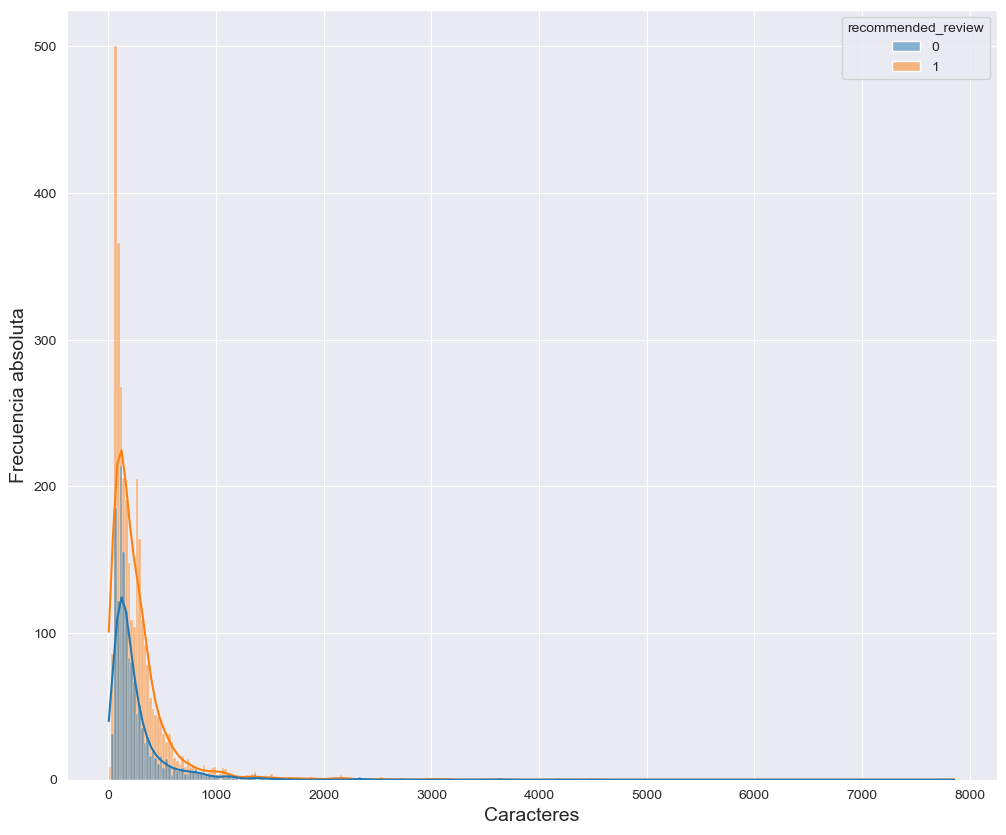

In [17]:
fig = plt.figure(figsize=(12,10))


sns.histplot(dataset,x="char_len", hue="recommended_review", kde=True)


plt.xlabel('Caracteres', fontsize=14)
plt.ylabel('Frecuencia absoluta', fontsize=14)

plt.show()

No hay una diferencia visualmente llamativa en la distribución de la longitud de las reviews que recomiendan y no recomiendan el producto.

**Observar sample del contenido de las reviews con recomendadas y no recomendas**

In [18]:
dataset.query("recommended_review ==1").sample(3).review_description.to_list()

['THE best FPS on the switch. I have not stop playing this game since I got it. Love the story mode AND the multiplayer. SO Fun and fast paced!',
 "granted, this isn't a ultra gaming monitor, so it doesn't have amazing specs, but it's a great value for it's price. 144 hrz made a big difference. my only complaint is that the stand is kind of oddly shaped, so it has a hard time sitting flush with my desk. all the weight seems to sit at the front of the stand, so i'm confused why it goes back like 5 inches. would also be nice if there was some sort of mounting hookup.",
 "[This review was collected as part of a promotion.] Got this to have a spare.  Its doesn't have the exact same feel in your hand as an original controller, and the toggles on the top are a little stiffer.  Other than that the functionality is pretty much spot on.  I love the retro look to the controller.  Im an old school Mario fan, so this is definitely spot on for my taste."]

In [19]:
dataset.query("recommended_review ==0").sample(3).review_description.to_list()

["It's a fun game I just dont like how it plays short films that you can not skip and I've been unable to find a way to purchase other cars through points I've earned in the game.",
 "You guys sent me a European Game. I meanit works fine and everything it's still in english and the Switch is region free but don't you guys not take foreign games?",
 'It’s a fun game great graphics and dope cars definitely recommend']

Parece que hay una etiqueta importante en las reviews que es "[This review was collected as part of a promotion.]". Esta etiqueta no contribuye a la sintaxis del documento y probablemente funcione mejor como una variable separada a tener en cuenta en la tarea de clasificación de sentimiento.

In [20]:
dataset["promoted"] = np.where(dataset["review_description"].str.startswith("[This review was collected as part of a promotion.]"), 1, 0).astype(int)
dataset["review_description"] = dataset["review_description"].replace({"[This review was collected as part of a promotion.] ":""})
dataset["promoted"].value_counts()

promoted
0    3676
1    1008
Name: count, dtype: int64

## 1. Preprocesado y Normalización

- Eliminar símbolos, separar palabras unidas por guiones, eliminar acentos, etc.
- Reemplazar jerga
- Normalizar palabras elongadas
- Normalizar contracciones
- Corregir ortografía
- Pasar a minúsculas
- Tokenizar
- Eliminar signos de puntuación y stopwords

A diferencia de otros campos, no se ha demostrado que la lematización ayude a mejorar el rendimiento de los clasificadores de sentimiento por lo que no es necesario aplicarla.

In [21]:
slang_dict = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [32]:
nlp = en_core_web_sm.load()

KeyboardInterrupt: 

In [23]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
punctuation = string.punctuation

In [29]:
def replace_slang(text):
    words = text.split()
    new_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(new_words)

def normalize_elongations(text):
    corrected_text = text
    corrected_text = re.sub(r'(\w)\1{2,}', r'\1\1', corrected_text)
    return corrected_text

preprocess = preprocessing.make_pipeline(
    preprocessing.normalize.hyphenated_words,
    preprocessing.normalize.quotation_marks,
    preprocessing.normalize.unicode,
    preprocessing.remove.accents,
    partial(preprocessing.replace.emails, repl="_EMAIL_"),
    partial(preprocessing.replace.phone_numbers, repl="_PhoneNumber_"),
    partial(preprocessing.replace.urls, repl="_URL_"),
    partial(preprocessing.replace.user_handles, repl="_UserHandle_"),
    partial(preprocessing.replace.numbers, repl="_NUMBER_"),
    preprocessing.remove.html_tags,
    preprocessing.remove.brackets,
    preprocessing.replace.currency_symbols,
    preprocessing.replace.emojis,
    replace_slang,
    normalize_elongations,
    contractions.fix
)

def tokenizer(sentence):

    sentence = preprocess(sentence)

    # sentence = str(TextBlob(sentence).correct())

    my_tokens = nlp(sentence)

    my_tokens = [word.lower_.strip() for word in my_tokens ]

    my_tokens = [word for word in my_tokens if word not in spacy_stopwords and word not in punctuation]

    return my_tokens

In [30]:
dataset["review_description_processed"] = dataset["review_description"].progress_apply(lambda x: tokenizer(x))

100%|██████████| 4684/4684 [01:58<00:00, 39.57it/s]


## 2. Análisis exploratorio de los datos

#### Términos más frecuentes

In [28]:
processed_descriptions = dataset['review_description_processed'].apply(lambda x: ','.join(x))

long_string = ','.join(processed_descriptions.values)

wordcloud = WordCloud(background_color="white", max_words=100, contour_width=0, contour_color='steelblue')

wordcloud.generate(long_string)

wordcloud.to_image()

KeyError: 'review_description_processed'

#### Diferencias en la distribución

In [ ]:
df_exploded = dataset[["review_description_processed","recommended_review"]].explode('review_description_processed')
words_pos_neg = pd.DataFrame(df_exploded.value_counts()).reset_index(level="recommended_review")

words_positive = df_exploded.query("recommended_review == 1")["review_description_processed"].value_counts(normalize=True)
words_negative = df_exploded.query("recommended_review == 0")["review_description_processed"].value_counts(normalize=True)

print(f"El número de palabras distintas para las reviews que recomiendan el producto es de {len(words_positive)}, mientras que el de las que no recomiendan es de {len(words_negative)}.")

El número de palabras distintas para las reviews que recomiendan el producto es de 7844, mientras que el de las que no recomiendan es de 5110.


Análisis descriptivo de las reviews que recomiendan el producto:


count    7844.000000
mean        0.000127
std         0.000696
min         0.000015
25%         0.000015
50%         0.000029
75%         0.000059
max         0.040407
Name: proportion, dtype: float64


Análisis descriptivo de las reviews que no recomiendan el producto:


count    5110.000000
mean        0.000196
std         0.000759
min         0.000037
25%         0.000037
50%         0.000037
75%         0.000147
max         0.032443
Name: proportion, dtype: float64

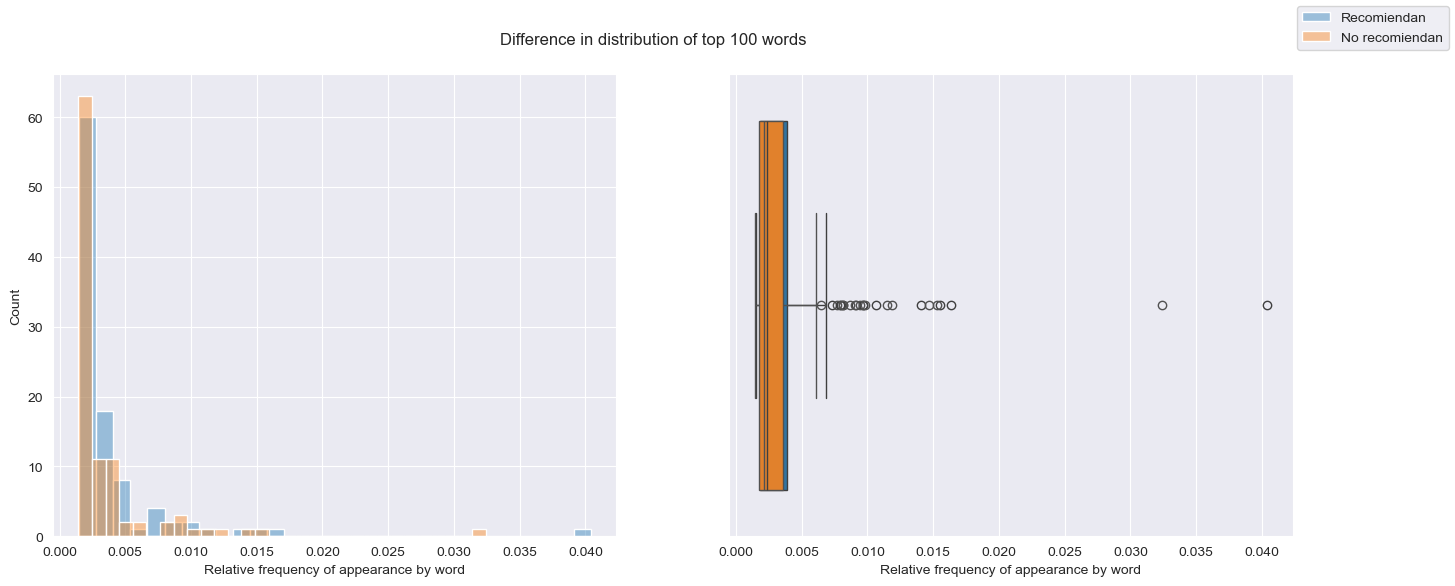

In [ ]:
print("Análisis descriptivo de las reviews que recomiendan el producto:")
display(words_positive.describe())
print("\nAnálisis descriptivo de las reviews que no recomiendan el producto:")
display(words_negative.describe())

fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(ncols=2,nrows=1)
ax1 = fig.add_subplot(gs[:,0])
sns.histplot(pd.DataFrame(words_positive[:100]),x="proportion",bins=30, alpha=0.4, label="Recomiendan")
sns.histplot(pd.DataFrame(words_negative[:100]),x="proportion",bins=30, alpha=0.4, label="No recomiendan")
fig.suptitle("Difference in distribution of top 100 words",y=0.95)
ax1.set_xlabel("Relative frequency of appearance by word")
fig.legend()

ax2 = fig.add_subplot(gs[:,1])
sns.boxplot(pd.DataFrame(words_positive[:100]),x="proportion")
sns.boxplot(pd.DataFrame(words_negative[:100]),x="proportion")
ax2.set_xlabel("Relative frequency of appearance by word")



plt.show()

Observando la estadística descriptiva las reviews que recomiendan el producto hay ligeramente algo más de dispersión en cuanto a la frecuencia relativa de aparición de las palabras, sin embargo visualmente no se aprecia diferencia en su distribución. Conviene por lo tanto realizar un test de contraste chi-cuadrado para comprobar si la diferencia entre las distribuciones es significativa.

In [ ]:
top_100_words_positive = (pd.DataFrame(words_positive[:100])
                          .assign(not_recommended = words_negative[words_positive[:100].index].values,words = words_negative[words_positive[:100].index].index)
                          .rename(columns={"proportion":"recommended"}))

contingency_table = top_100_words_positive[['recommended', 'not_recommended']].values

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared Statistic: {chi2}")
print(f"P-value: {p}")
if p < 0.05:
    print("The difference in word distributions is significant.")
else:
    print("The difference in word distributions is not significant.")

Chi-squared Statistic: 0.03734137750767689
P-value: 1.0
The difference in word distributions is not significant.


El test confirma lo que se apreciaba visualmente a través de los gráficos, no existe diferencia significativa entre las distribuciones. Este hecho podría estar en parte explicado por la alta incidencia de reviews promocionadas.

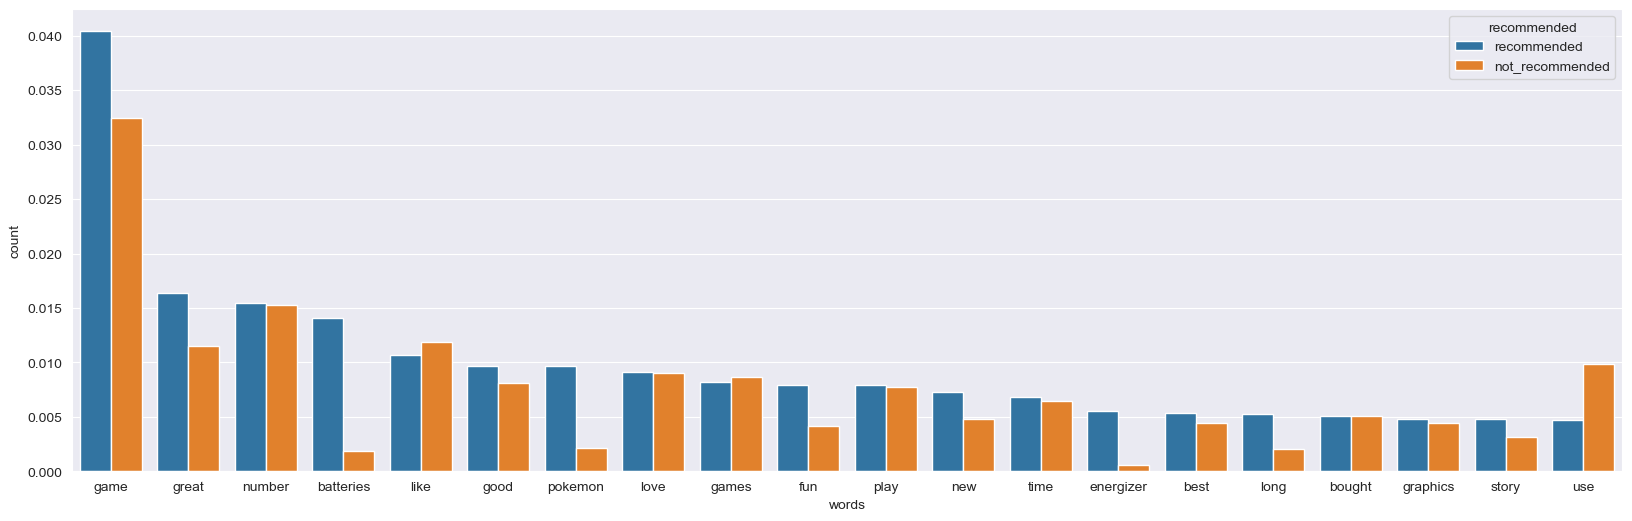

In [ ]:
top_20_words_positive_melted = pd.melt(top_100_words_positive[:20],id_vars=['words'], value_vars=['recommended', 'not_recommended'], 
                    var_name='recommended', value_name='count')

# Histogramas de frecuencia de palabras
plt.figure(figsize=(20, 6))

sns.barplot(data = top_20_words_positive_melted, x="words",y="count",hue="recommended",)

plt.show()


## 3. Análisis de sentimiento

In [27]:
glove_emb_twitter = api.load('glove-twitter-200')

KeyboardInterrupt: 

In [ ]:
def get_embedding(tokens, embedding_dim):
    embeddings = []
    for token in tokens:
        if token in glove_emb_twitter.index_to_key: 
            embeddings.append(glove_emb_twitter[token])
        else:
            embeddings.append(np.zeros(embedding_dim))  
    if embeddings:
        return np.mean(embeddings, axis=0)  
    else:
        return np.zeros(embedding_dim)  


In [ ]:
embedding_dim = glove_emb_twitter.vector_size  
dataset["document_embeddings"] = dataset["review_description_processed"].progress_apply(lambda x: get_embedding(x,embedding_dim))

100%|██████████| 4684/4684 [02:29<00:00, 31.23it/s] 


In [51]:
def get_sentiment(rating):
    if rating > 3:
        return '2'
    elif rating == 3:
        return '1'
    else:
        return '0'

dataset["label"] = dataset['rating'].progress_apply(lambda x: get_sentiment(x))

100%|██████████| 4684/4684 [00:00<00:00, 584845.20it/s]


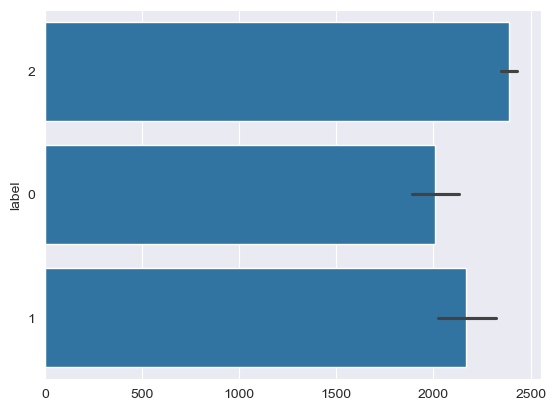

In [54]:
sns.barplot(dataset["label"])

plt.show()

In [59]:
encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(dataset["label"].to_numpy().reshape(-1, 1))

In [104]:
dataset["promoted"]
pd.DataFrame(dataset['document_embeddings'].tolist())

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.089642,0.173897,-0.018808,-0.022355,0.004840,-0.099518,0.408386,-0.029465,-0.029088,-0.058968,...,0.201645,0.041909,0.139821,0.047222,0.062017,-0.064410,-0.009863,0.125482,-0.057934,-0.086009
1,-0.019331,0.105160,-0.081120,0.012564,0.001201,0.078062,0.439015,0.008094,0.050861,-0.091967,...,0.119340,-0.086558,0.053499,-0.207730,0.019101,-0.092115,0.135180,0.188583,-0.049376,0.057160
2,-0.100705,0.201200,-0.016136,0.190166,-0.261518,0.100347,0.819073,-0.079485,0.098280,-0.150145,...,0.128618,0.127043,0.091690,0.130422,0.170817,0.184823,0.164864,0.195543,-0.073821,-0.073403
3,0.044449,0.016817,-0.006086,0.079389,-0.015144,0.054223,0.534071,-0.107516,0.001660,-0.074029,...,0.116998,-0.018058,0.085714,-0.030197,0.085261,0.044586,0.089985,0.150563,-0.115233,-0.043258
4,0.149975,0.089670,-0.132027,0.027844,0.021831,0.024241,0.378146,-0.123040,0.002373,-0.212843,...,0.225831,0.026689,0.187443,0.017594,0.108861,-0.100618,0.033249,0.096439,-0.053725,-0.151483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4679,0.129064,0.074593,0.102412,0.082405,0.019613,0.171794,0.601178,-0.093107,0.090304,-0.160947,...,-0.192061,0.221043,0.027595,-0.202401,-0.056568,-0.131701,0.076215,-0.075532,-0.242567,0.064445
4680,0.044088,0.037880,-0.140102,-0.053907,0.102341,0.161414,0.474508,-0.094232,-0.077800,-0.193805,...,0.006155,0.007535,0.160670,-0.074134,0.134922,0.033264,0.043000,0.034596,-0.023300,-0.049972
4681,-0.003781,0.095128,0.096301,-0.125647,0.047437,0.419568,0.342655,-0.138421,0.052031,-0.037666,...,-0.160776,-0.046990,0.226191,-0.081279,0.048172,-0.138890,0.078662,0.111261,-0.074735,0.066938
4682,-0.003403,0.281870,0.053236,-0.119257,0.107565,0.271948,0.244101,0.005816,-0.178191,-0.169257,...,-0.156800,-0.028390,0.264879,0.021369,0.119638,0.007679,0.147685,0.174180,-0.179976,0.337525


In [120]:
X = pd.concat([pd.DataFrame(dataset['document_embeddings'].tolist()),dataset["promoted"].reset_index(drop=True)],axis=1).values
y = dataset["label"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

Se pre-escogen 4 algoritmos de clasificación estándar para comparar el rendimiento de los mismos mediante validación cruzada con el area bajo la curva ROC (AUC) como métrica de clasificación. Se escoge esta métrica por ser agnóstica del punto de decisión o umbral de clasificación a diferencia de la precision y el recall o el f1, resumiendo el desempeño de todos los puntos ROC, y que funciona bien cuando las clases están balanceadas.

In [122]:
def model_evaluation(models, X, y):
    results = []
    names = []
    auc_scores = [] 
    
    # For each model
    for name, model in models:
        warnings.filterwarnings('ignore') 

        KF = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

        # Compute ROC-AUC score using cross-validation
        y_prob = cross_val_predict(model, X, y, cv=KF, method='predict_proba')
        label_binarizer = LabelBinarizer()
        y_bin = label_binarizer.fit_transform(y)
        auc_score = roc_auc_score(y_bin, y_prob, average='macro')
        auc_scores.append(auc_score)

        results.append(auc_score)
        names.append(name)
        
        print('Model:', name)
        print("ROC-AUC Score:", auc_score)
        print("\n")

    return results, names, auc_scores

models = [
    ("Logistic Regression", LogisticRegression(multi_class='multinomial',random_state=seed)),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("Random Forest", RandomForestClassifier(random_state=seed)),
    ("SVM", SVC(probability=True, random_state=seed)) 
]

results, names, auc_scores = model_evaluation(models, X_train, y_train)


Model: Logistic Regression
ROC-AUC Score: 0.8367756088223598


Model: Gaussian Naive Bayes
ROC-AUC Score: 0.7616468039277814


Model: Random Forest
ROC-AUC Score: 0.7762100444143506


Model: SVM
ROC-AUC Score: 0.8227205351151629


